                                                         ИМПОРТИРОВАНИЕ МОДУЛЕЙ

In [1]:
import scipy.stats as sps
import scipy.optimize as spo
import scipy.special as scs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import pyreadr

                                                   ГЕНЕРАЦИЯ МАССИВОВ ВЫБОРОК РАСПРЕДЕЛЕНИЯ

In [2]:
def normal_array(N,T,mu,sigma):
    A=np.zeros([N,T])
    for i in range(N):
        A[i,:]=sps.norm.rvs(loc=mu,scale=sigma,size=T)
    return A

def gamma_array(N,T,alpha,loc,scale):
    A=np.zeros([N,T])
    for i in range(N):
        A[i,:]=sps.gamma.rvs(a=alpha,loc=loc,scale=scale,size=T)
    return A

def student_array(N,T,df,loc,scale):
    A=np.zeros([N,T])
    for i in range(N):
        A[i,:]=sps.t.rvs(df=df,loc=loc,scale=scale,size=T)
    return A

In [ ]:
#####################################################################################################################################################
#                                       Н А Р Е З К А    В Ы Б О Р К И     Н А     П О Д В Ы Б О Р К И
#####################################################################################################################################################

# ТОЧКИ НАРЕЗКИ ЗАДАЮТСЯ СПИСКОМ

def cutting(data,List):        # data - список или одномерный массив,  List - список
    def ListList(N):           # создает список длины len(List), элементы которого пустые списки
        A=[]
        for i in range(N):
            A.append([])
        return(A)
    data=list(data)
    if not List[0]==0:                      # Если начальный элемент списка List не равен нулю, к результату добавляется          
        List.insert(0, 0)                   # начальный фрагмент [data[0]:data[List[0]]
    if not List[len(List)-1]==len(data):    # Если конечный элемент списка List не длине массива(списка) data, 
        List.append(len(data))              # к результату добавляется конечный фрагмент [data[List[-1]:data[len(data)]
    A=ListList(len(List)-1)
    for i in range(len(A)):
        A[i]=(data[List[i]:List[i+1]])    
    return A
####################################################################################################################################################
# НАРЕЗКА НА ПОДВЫБОРКИ ФИКСИРОВАННОЙ ДЛИНЫ

def subsamples(data,T,frombegin):             
# data - список или массив np.array
# T - объем (длина) подвыборок
# Если frombegin=True, нарезка идет от начала u отбрасывается конец, иначе - нарезка идет от конца
    data=list(data)
    n=len(data)//T                              # n - количество подвыборок
    rest=len(data)%n
    if frombegin==False:                            
        data=data[rest:(len(data))]
    else:
        data=data[0:n*T]
    List = []
    for i in range(n):
        List.append(i*T)
    Subs=cutting(data,List)
    for i in range(len(Subs)):
        Subs[i]=np.array(Subs[i])
    return Subs                                      # Подвыборки - одномерные массивы

####################################################################################################################################################
# НАРЕЗКА МАССИВА НА ПОДВЫБОРКИ ФИКСИРОВАННОЙ ДЛИНЫ

def subsamples_array(data,T,frombegin,axis):
# data - двумерный массив
# T - длина подвыборки
# axis=0 - разбиение идет по столбцам (количество строк = [исходное количество строк/T]
# axis=1 - разбиение идет по столбцам (количество столбцов = [исходное количество столбцов/T]
    N0=data.shape[0]
    N1=data.shape[1]
    if axis==0:
        n=N0//T
        SUBS=np.zeros([n,T,N1])
        for k in range(n):
            for j in range(N1):
                SUBS[k,:,j]=subsamples(data[:,j],T,True)[k]
    if axis==1:
        n=N1//T
        SUBS=np.zeros([n,N0,T])
        for k in range(n):
            for i in range(N0):
                SUBS[k,i,:]=subsamples(data[i,:],T,True)[k]
    return SUBS

                                                    ЭМПИРИЧЕСКАЯ ПЛОТНОСТЬ ВЕРОЯТНОСТИ

In [3]:
# ГИСТОГРАММА

#np.histogram(data, bins=10, range=None, density=None, weights=None)
# range  = (,) - нижнее и верхнее значение диапазона (по умолчанию (min(data),max(data))
# bins - точки разбиения диапазона (можно задать как список или числом - тогда промежутки будут равными)
# density - если density=True, гистограмма нормируется на единицу

#################################################################################################################################

# ЭМПИРИЧЕСКАЯ ПЛОТНОСТЬ
def empiric_density(data, number_breaks, mindata, maxdata):                      # data - np.array(N,);   N=data.shape[0]
    data=np.array(data)
    step=(maxdata-mindata)/number_breaks
    breaks=mindata+step*range(0,number_breaks+1)
    mids=mindata+step/2+step*range(0,number_breaks)
    density=(maxdata-mindata)/(max(data)-min(data))*np.histogram(data,bins=number_breaks,range=(mindata, maxdata),density=True)[0]
    # эмпирическая плотность отнормирована на диапазон - интеграл от плотности на диапазоне равен единице
    return([mids],[density])
##################################################################################################################################
# ИЗВЛЕКАЕТ ИЗ ФУНКЦИИ empiric_density ЧАСТОСТИ КАК np.array (n,)

def Y_density(data,number_breaks):
    return np.array(empiric_density(data, number_breaks,mindata=min(data), maxdata=max(data)))[1,0,:]
def Y_cumulative(data,number_breaks):
    return np.array(empiric_cumulative_density(data, number_breaks,mindata=min(data), maxdata=max(data)))[1,0,:]

##################################################################################################################################
# ЭМПИРИЧЕСКАЯ ПЛОТНОСТЬ И ЕЕ ГРАФИК
    # На график эмпирической плотности можно накладывать различные кривые - графики функций из списка [F]

def Empiric_density(data, number_breaks, F,colors,mindata, maxdata,MEAN):
    # data - np.array (одномерный)
    # F - список функций
    # colors - список цветов
    # mindata,maxdata - границы графика
    # MEAN - если MEAN=True, наносится вертикальная линия - среднее значение data
    Dens=empiric_density(data, number_breaks, mindata, maxdata)
    plt.figure()
    X1=list()
    Y1=list()
    
    for i in range(Dens[0][0].shape[0]):
        X1.append(np.array(Dens[0])[0,i])
        Y1.append(np.array(Dens[1])[0,i])
    Z=np.zeros([len(F),Dens[0][0].shape[0]])
    plt.plot(X1,Y1,'b')
    for i in range(len(F)):
        Z[i,:]=np.vectorize(F[i])(X1)
        plt.plot(X1,Z[i],color=colors[i])
    plt.title('EMPIRIC DENSITY')
    plt.xlabel('breaks')
    plt.ylabel('probabilities')
    plt.grid()
    plt.axvline(lw=3,color='k',x=0)
    plt.axhline(lw=3,color='k',y=0)
    if MEAN==True:
        plt.axvline(lw=3,color='g',x=np.mean(data))
    return plt.show

                                                         ЭМПИРИЧЕСКАЯ ФУНКЦИЯ РАСПРЕДЕЛЕНИЯ

In [4]:
# ЭМПИРИЧЕСКАЯ ФУНКЦИЯ РАСПРЕДЕЛЕНИЯ
def empiric_cumulative_density(t,data,less):
    if t<=min(data):
        return 0
    if t>=max(data):
        return 1
    data=sorted(list(data))
    if t<data[0]:
        return 0
    leftx=list(filter(lambda x: x<=t, data))[-1]
    rightx=list(filter(lambda x: x>t, data))[0]
    left_index=data.index(leftx)
    right_index=data.index(rightx)
    if less==True:
        leftF=left_index/len(data)
        rightF=right_index/len(data)
    else:
        leftF=(left_index+1)/len(data)
        rightF=(right_index+1)/len(data)
    Fdistrx=leftF+(rightF-leftF)/(rightx-leftx)*(t-leftx)
    return Fdistrx

#######################################################################################################################################
# ЭМПИРИЧЕСКАЯ ФУНКЦИЯ РАСПРЕДЕЛЕНИЯ И ЕЕ ГРАФИК
    # На график эмпирической плотности можно накладывать различные кривые - графики функций из списка [F]

def Empiric_cumulative_density(data,number_breaks,F,colors,less,MEAN):
    step=(max(data)-min(data))/number_breaks
    X1=np.zeros(number_breaks)
    Y1=np.zeros(number_breaks)
    for i in range(number_breaks):
        X1[i]=min(data)+i*step
        Y1[i]=empiric_cumulative_density(X1[i],data,less)
    Z=np.zeros([len(F),X1.shape[0]])
    plt.plot(X1,Y1,'b')
    for i in range(len(F)):
        Z[i,:]=np.vectorize(F[i])(X1)
        plt.plot(X1,Z[i],color=colors[i])
    plt.title('EMPIRIC DENSITY')
    plt.xlabel('breaks')
    plt.ylabel('probabilities')
    plt.grid()
    plt.axvline(lw=3,color='k',x=0)
    plt.axhline(lw=3,color='k',y=0)
    if MEAN==True:
        plt.axvline(lw=3,color='g',x=np.mean(data))
    return plt.show()

In [ ]:
                                                                 ЭМПИРИЧЕСКИЙ КВАНТИЛЬ

In [5]:
# КВАНТИЛЬ ЭМПИРИЧЕСКОГО РАСПРЕДЕЛЕНИЯ

def empiric_ppf(data,alpha):
    data=list(data)
    sorted_data=sorted(data)
    return sorted_data[round(alpha*len(data))]

                                                             СТАТИСТИЧЕСКИЙ АНАЛИЗ ТЕСТА

In [13]:
def pval_stat1(A,alpha):
    B=np.zeros(A.shape[0])
    for i in range(A.shape[0]):
        if A[i]>alpha:
            B[i]=1
        else:
            B[i]=0
    count=np.sum(B)/A.shape[0]
    return count

def pval_stat2(A,alpha,axis):
    B=np.zeros([A.shape[0],A.shape[1]])
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if A[i,j]>alpha:
                B[i,j]=1
            else:
                B[i,j]=0
    count=np.sum(B,axis=axis)/A.shape[axis]
    return count

                            Т Е С Т     К О Л М О Г О Р О В А - С М И Р Н О В А     Н А     О Д Н О Р О Д Н О С Т Ь

                                                             НОРМАЛЬНОЕ РАСПРЕДЕЛЕНИЕ

In [19]:
# БОЛЬШОЙ МАССИВ ВЫБОРОК

# Параметры массива
N_norm_KS=10000       # Количество выборок
m_norm_KS=50          # Длины выборок
n_norm_KS=50

# Параметры выборок
mu1_KS=0
mu2_KS=0.2
sigma1_KS=1
sigma2_KS=1.5

# Генерация массива выборок
ARRAY_norm1_KS=normal_array(N_norm_KS,T=m_norm_KS,mu=0,sigma=sigma1_KS)
ARRAY_norm2_KS=normal_array(N_norm_KS,T=n_norm_KS,mu=0,sigma=sigma2_KS)

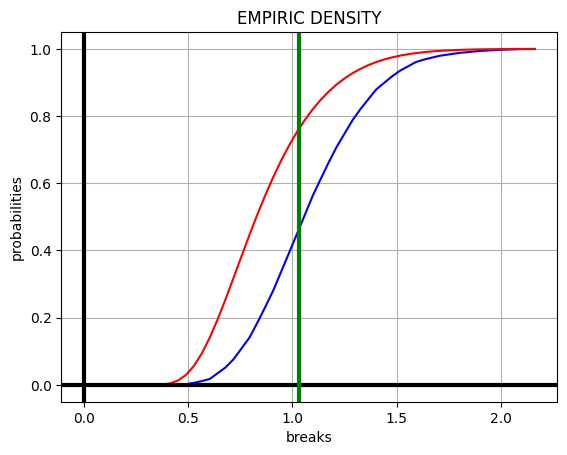

In [20]:
# Статистика Колмогорова-Смирнова
D_norm=np.zeros(N_norm_KS)
for i in range(N_norm_KS):
    D_norm[i]=sps.ks_2samp(ARRAY_norm1_KS[i,:],ARRAY_norm2_KS[i,:]).statistic*((m_norm_KS*n_norm_KS)/(m_norm_KS+n_norm_KS))**0.5

# Визуализация
Empiric_cumulative_density(data=D_norm,number_breaks=min(m_norm_KS,n_norm_KS),F=[sps.kstwobign.cdf],colors=['r'],less=False,MEAN=True)

In [21]:
# Тест Колмогорова-Смирнова

KS_test_norm=[]
for i in range(N_norm_KS):
    KS_test_norm.append([])
KS_norm_statistic=np.zeros(N_norm_KS)
KS_norm_pvalue=np.zeros(N_norm_KS)
for i in range(len(KS_test_norm)):
    KS_test_norm[i]=sps.ks_2samp(ARRAY_norm1_KS[i,:],ARRAY_norm2_KS[i,:],alternative='two-sided')
    KS_norm_statistic[i]=KS_test_norm[i][0]
    KS_norm_pvalue[i]=KS_test_norm[i][1]
KS_norm_pvalue.shape


(10000,)

In [22]:
# Статистический анализ

alpha_KS=0.1
KS_norm_stat=pval_stat1(KS_norm_pvalue,alpha_KS)
KS_norm_stat

0.8

                                                                  ГАММА-РАСПРЕДЕЛЕНИЕ

In [ ]:
# Параметры массива
m_gamma_KS=50
n_gamma_KS=50
N_gamma_KS=1000

# Параметры выборок
alpha_gamma_KS1=1
alpha_gamma_KS2=1.2

# Генерация массива выборок
ARRAY_gamma1_KS=gamma_array(N_gamma_KS,T=m_gamma_KS,alpha=alpha_gamma_KS1,loc=0,scale=1)
ARRAY_gamma2_KS=gamma_array(N_gamma_KS,T=n_gamma_KS,alpha=alpha_gamma_KS2,loc=0,scale=1)

# Статистика Колмогорова-Смирнова
D_gamma=np.zeros(N_gamma_KS)
for i in range(N_gamma_KS):
    D_gamma[i]=sps.ks_2samp(ARRAY_gamma1_KS[i,:],ARRAY_gamma2_KS[i,:]).statistic*((m_gamma_KS*n_gamma_KS)/(m_gamma_KS+n_gamma_KS))**0.5

# Визуализация
Empiric_cumulative_density(data=D_gamma,number_breaks=min(m_gamma_KS,n_gamma_KS),F=[sps.kstwobign.cdf],colors=['r'],less=False,MEAN=True)

In [ ]:
# Тест Колмогорова-Смирнова

KS_test_gamma=[]
for i in range(N_gamma_KS):
    KS_test_gamma.append([])
KS_gamma_statistic=np.zeros(N_gamma_KS)
KS_gamma_pvalue=np.zeros(N_gamma_KS)
for i in range(len(KS_test_gamma)):
    KS_test_gamma[i]=sps.ks_2samp(ARRAY_gamma1_KS[i,:],ARRAY_gamma2_KS[i,:],alternative='two-sided')
    KS_gamma_statistic[i]=KS_test_gamma[i][0]
    KS_gamma_pvalue[i]=KS_test_gamma[i][1]
KS_gamma_pvalue

In [ ]:
# Статистический анализ

alpha_KS=0.1
KS_gamma_stat=pval_stat1(KS_gamma_pvalue,alpha_KS)
KS_gamma_stat

In [ ]:
                                        Т Е С Т    Н А    Р А В Е Н С Т В О      Д И С П Е Р С И Й

In [23]:
# ТЕСТ НА РАВЕНСТВО ДИСПЕРСИЙ

def F_test(data1, data2,alpha,two_sided=False):
    data1 = np.array(data1)
    data2 = np.array(data2)
    var1=np.var(data1,ddof=1)
    var2=np.var(data2,ddof=2)
    
# F-статистика    
    if two_sided==True:
        F = var1/var2
        dfn = data1.shape[0]-1                                    # Количество степеней свободы числителя
        dfd = data2.shape[0]-1                                    # Количество степеней свободы знаменателя
        pval_left=sps.f.cdf(F,dfn,dfd)
        pval_right=1-sps.f.cdf(F,dfn,dfd)
        pvalue=[pval_left,pval_right]
        if pval_left<alpha/2 or pval_right<alpha/2:
            result=0
        else:
            result=1
        
    else:
        if var1>var2:
            F=var1/var2
            dfn = data1.shape[0]-1                                    # Количество степеней свободы числителя
            dfd = data2.shape[0]-1                                    # Количество степеней свободы знаменателя
        else:
            F=var2/var1
            dfn = data2.shape[0]-1                                    # Количество степеней свободы числителя
            dfd = data1.shape[0]-1                                    # Количество степеней свободы знаменателя
        pvalue=1-sps.f.cdf(F, dfn, dfd)
        if pvalue<alpha:
            result=0
        else:
            result=1
    return [F,pvalue,result]


In [ ]:
                                                Н о р м а л ь н о е      р а с п р е д е л е н и е

In [33]:
# Количество выборок
N_norm_F=1000

# Длины выборок
T_norm1_F=50
T_norm2_F=50

# Дисперсии выборок
sigma1_F=1
sigma2_F=1.5

# Генерация массива выборок
ARRAY_NORM1_F=normal_array(N=N_norm_F,T=T_norm1_F,mu=0,sigma=sigma1_F)
ARRAY_NORM2_F=normal_array(N=N_norm_F,T=T_norm2_F,mu=0,sigma=sigma2_F)

In [34]:
# Тест Фишера

alpha_F=0.1
F_test_normal_one_sided=np.zeros(N_norm_F)
F_test_normal_two_sided=np.zeros(N_norm_F)
for i in range(N_norm_F):
    F_test_normal_one_sided[i]=F_test(ARRAY_NORM1_F[i,:],ARRAY_NORM2_F[i,:],alpha=alpha_F,two_sided=False)[2]
    F_test_normal_two_sided[i]=F_test(ARRAY_NORM1_F[i,:],ARRAY_NORM2_F[i,:],alpha=alpha_F,two_sided=True)[2]
F_test_normal_result=np.zeros([N_norm_F,2])
F_test_normal_result[:,0]=F_test_normal_one_sided
F_test_normal_result[:,1]=F_test_normal_two_sided
F_test_normal_result

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [1., 1.]])

In [35]:
# Статистический анализ
[int(np.sum(F_test_normal_result[:,0]))/N_norm_F, int(np.sum(F_test_normal_result[:,1]))/N_norm_F]


[0.051, 0.102]

                                                   Г а м м а     р а с п р е д е л е н и е

In [40]:
# Параметры массива
N_gamma_F=10000
T1_gamma_F=50
T2_gamma_F=50

# Параметры выборок
alpha_gamma1=2
alpha_gamma2=2.5
alpha_Ftest=0.1

# Генерация массива выборок
ARRAY_GAMMA1_F=gamma_array(N=N_gamma_F,T=T1_gamma_F,alpha=alpha_gamma1,loc=0,scale=1)
ARRAY_GAMMA2_F=gamma_array(N=N_gamma_F,T=T2_gamma_F,alpha=alpha_gamma2,loc=0,scale=1)

<function matplotlib.pyplot.show(close=None, block=None)>

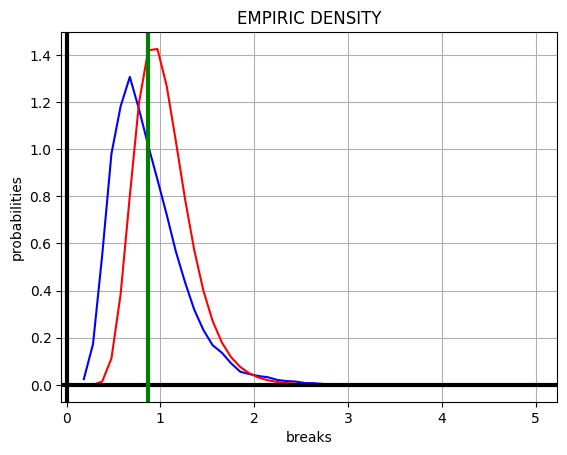

In [41]:

Vars_gamma1=np.var(ARRAY_GAMMA1_F,ddof=1,axis=1)
Vars_gamma2=np.var(ARRAY_GAMMA2_F,ddof=1,axis=1)

# Построение статистики Фишера и визуализация
F_gamma=Vars_gamma1/Vars_gamma2
def fFisher_gamma(x):
    return sps.f.pdf(x,dfn=T1_gamma_F-1,dfd=T2_gamma_F-1)
Empiric_density(data=F_gamma, number_breaks=round(N_gamma_F/200), F=[fFisher_gamma],colors=['r'],mindata=min(F_gamma), maxdata=max(F_gamma),MEAN=True)

In [42]:
# Тест Фишера

alpha_F=0.1
F_test_gamma_one_sided=np.zeros(N_gamma_F)
F_test_gamma_two_sided=np.zeros(N_gamma_F)
for i in range(N_gamma_F):
    F_test_gamma_one_sided[i]=F_test(ARRAY_GAMMA1_F[i,:],ARRAY_GAMMA2_F[i,:],alpha=alpha_F,two_sided=False)[2]
    F_test_gamma_two_sided[i]=F_test(ARRAY_GAMMA1_F[i,:],ARRAY_GAMMA2_F[i,:],alpha=alpha_F,two_sided=True)[2]
F_test_gamma_result=np.zeros([N_gamma_F,2])
F_test_gamma_result[:,0]=F_test_gamma_one_sided
F_test_gamma_result[:,1]=F_test_gamma_two_sided
F_test_gamma_result

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       ...,
       [1., 1.],
       [0., 1.],
       [1., 1.]])

In [43]:
[int(np.sum(F_test_gamma_result[:,0]))/N_gamma_F, int(np.sum(F_test_gamma_result[:,1]))/N_gamma_F]

[0.5391, 0.6615]

                                              Р а с п р е д е л е н и е      С т ь ю д е н т а

In [49]:
# Параметры массива
N_t_F=10000       # количество выборок
T1_t_F=50         # длины выборок
T2_t_F=50

# Параметры выборки
df1_t_F=5        # количество степеней свободы
df2_t_F=10
scale_t_F=1

# Генерация массива выборок
ARRAY_STUD1_F=student_array(N=N_t_F,T=T1_t_F,df=df1_t_F,loc=0,scale=scale_t_F)
ARRAY_STUD2_F=student_array(N=N_t_F,T=T2_t_F,df=df2_t_F,loc=0,scale=scale_t_F)

# Выборочные дисперсии
Vars_t_1=np.var(ARRAY_STUD1_F,ddof=1,axis=1)
Vars_t_2=np.var(ARRAY_STUD2_F,ddof=1,axis=1)

<function matplotlib.pyplot.show(close=None, block=None)>

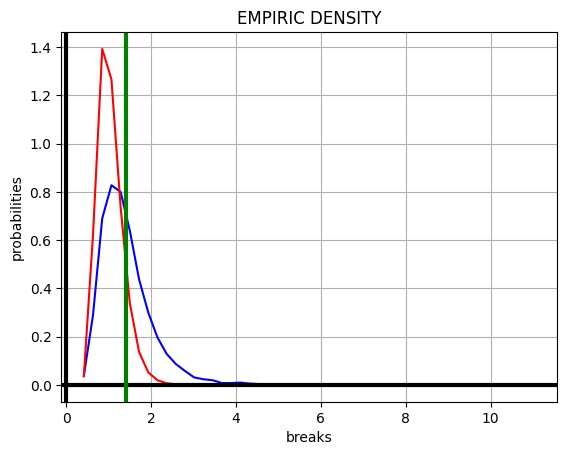

In [50]:
# Построение статистики Фишера и визуализация
F_t=Vars_t_1/Vars_t_2
def fFisher_t(x):
    return sps.f.pdf(x,dfn=T1_t_F-1,dfd=T2_t_F-1)
Empiric_density(data=F_t, number_breaks=round(N_t_F/200), F=[fFisher_t],colors=['r'],mindata=min(F_t), maxdata=max(F_t),MEAN=True)

In [51]:
# Сравнение квантилей эмпирического распределения статистики Фишера и распределения Стьюдента

alpha_F=0.1
left_empiric=empiric_ppf(F_t,alpha_F/2)
right_empiric=empiric_ppf(F_t,1-alpha_F/2)
left_t=sps.f.ppf(q=alpha_F/2,dfn=T1_t_F-1,dfd=T2_t_F-1)
right_t=sps.f.ppf(q=1-alpha_F/2,dfn=T1_t_F-1,dfd=T2_t_F-1)
[[left_empiric,left_t],[right_empiric,right_t]]


[[0.691616025161473, 0.6221654675017775],
 [2.5471953716000413, 1.6072894627459264]]

In [52]:
# Тест Фишера

F_test_t_one_sided=np.zeros(N_t_F)
F_test_t_two_sided=np.zeros(N_t_F)
for i in range(N_t_F):
    F_test_t_one_sided[i]=F_test(ARRAY_STUD1_F[i,:],ARRAY_STUD2_F[i,:],alpha=alpha_F,two_sided=False)[2]
    F_test_t_two_sided[i]=F_test(ARRAY_STUD1_F[i,:],ARRAY_STUD2_F[i,:],alpha=alpha_F,two_sided=True)[2]
F_test_t_result=np.zeros([N_t_F,2])
F_test_t_result[:,0]=F_test_t_one_sided
F_test_t_result[:,1]=F_test_t_two_sided
F_test_t_result

array([[1., 1.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [1., 1.],
       [1., 1.]])

In [53]:
[int(np.sum(F_test_t_result[:,0]))/N_t_F, int(np.sum(F_test_t_result[:,1]))/N_t_F]

[0.5736, 0.698]

           Т Е С Т     Н А     Р А В Е Н С Т В О      М А Т Е М А Т И Ч Е С К И Х     О Ж И Д А Н И Й     (С Р Е Д Н И Х)

                                                 НОРМАЛЬНОЕ РАСПРЕДЕЛЕНИЕ

In [54]:
# МОДЕЛИРУЕМЫЕ ПАРАМЕТРЫ

# Дисперсии 
sigma1_t=1                   
sigma2_t=1.5

# Длины выборок
T_norm1_t=50            
T_norm2_t=50

#  Количество степеней свободы
DF_norm_t=(sigma1_t/T_norm1_t+sigma2_t/T_norm2_t)**2/(1/(T_norm1_t-1)*(sigma1_t/T_norm1_t)**2+1/(T_norm2_t-1)*(sigma2_t/T_norm2_t)**2)
DF_norm_t


94.23076923076925

In [63]:
# БОЛЬШОЙ МАССИВ ВЫБОРОК 

N_norm_t=10000         # Количество выборок
mu1_t=0
mu2_t=0.5
ARRAY_NORM1_t=normal_array(N=N_norm_t,T=T_norm1_t,mu=mu1_t,sigma=sigma1_t)
ARRAY_NORM2_t=normal_array(N=N_norm_t,T=T_norm2_t,mu=mu2_t,sigma=sigma2_t)

Means_norm1_t=np.mean(ARRAY_NORM1_t,axis=1)      # выборочные средние
Means_norm2_t=np.mean(ARRAY_NORM2_t,axis=1)
Vars_norm1_t=np.var(ARRAY_NORM1_t,axis=1)          # выборочные дисперсии
Vars_norm2_t=np.var(ARRAY_NORM2_t,axis=1)

# t-статистика для тестирования гипотезы о равенстве средних
t_norm=(Means_norm1_t-Means_norm2_t)/(Vars_norm1_t/T_norm1_t+Vars_norm2_t/T_norm2_t)**0.5

<function matplotlib.pyplot.show(close=None, block=None)>

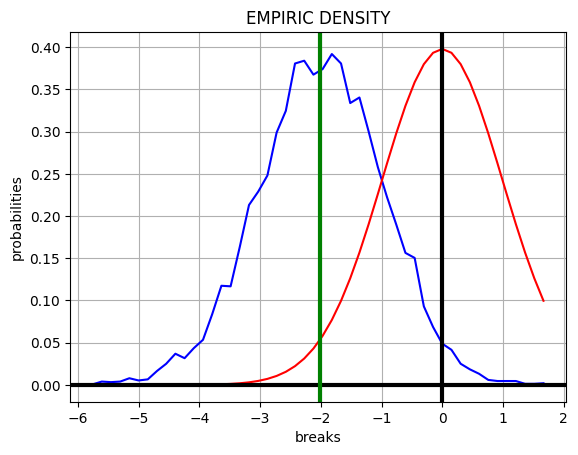

In [64]:
# ВИЗУАЛИЗАЦИЯ
def fStudent_norm(x):
    return sps.t.pdf(x,df=DF_norm_t,loc=0,scale=1)
Empiric_density(data=t_norm, number_breaks=round(N_norm_t/200), F=[fStudent_norm],colors=['r'],mindata=min(t_norm), maxdata=max(t_norm),MEAN=True)

In [65]:
# ТЕСТ НА РАВЕНСТВО МАТЕМАТИЧЕСКИХ ОЖИДАНИЙ - РАВНЫЕ ДИСПЕРСИИ

statistic_t_equaldisp=np.zeros(N_norm_t)
pvalue_t_equaldisp=np.zeros(N_norm_t)
for i in range(N_norm_t):
    # статистика Стьюдента
    statistic_t_equaldisp[i]=sps.ttest_ind_from_stats(mean1=Means_norm1_t[i], std1=Vars_norm1_t[i], nobs1=T_norm1_t, 
                     mean2=Means_norm2_t[i], std2=Vars_norm2_t[i], 
                     nobs2=T_norm2_t, equal_var=True, alternative='two-sided').statistic
    # pvalue
    pvalue_t_equaldisp[i]=sps.ttest_ind_from_stats(mean1=Means_norm1_t[i], std1=Vars_norm1_t[i], nobs1=T_norm1_t,
                     mean2=Means_norm2_t[i], std2=Vars_norm2_t[i], 
                     nobs2=T_norm2_t, equal_var=True, alternative='two-sided').pvalue
# Статистический анализ - равные дисперсии
alpha_t=0.1
t_norm_stat_equaldisp=pval_stat1(pvalue_t_equaldisp,alpha_t)
t_norm_stat_equaldisp        # частость принятия гипотезы в случае равных дисперсий

0.5963

In [66]:
# ТЕСТ НА РАВЕНСТВО МАТЕМАТИЧЕСКИХ ОЖИДАНИЙ - РАЗЛИЧНЫЕ ДИСПЕРСИИ

statistic_t_nonequaldisp=np.zeros(N_norm_t)
pvalue_t_nonequaldisp=np.zeros(N_norm_t)
for i in range(N_norm_t):
    # статистика Стьюдента
    statistic_t_nonequaldisp[i]=sps.ttest_ind_from_stats(mean1=Means_norm1_t[i], std1=Vars_norm1_t[i], nobs1=T_norm1_t, 
                     mean2=Means_norm2_t[i], std2=Vars_norm2_t[i], 
                     nobs2=T_norm2_t, equal_var=False, alternative='two-sided').statistic
    # pvalue
    pvalue_t_nonequaldisp[i]=sps.ttest_ind_from_stats(mean1=Means_norm1_t[i], std1=Vars_norm1_t[i], nobs1=T_norm1_t, 
                     mean2=Means_norm2_t[i], std2=Vars_norm2_t[i], 
                     nobs2=T_norm2_t, equal_var=False, alternative='two-sided').pvalue
# Статистический анализ - равные дисперсии
alpha_t=0.1
t_norm_stat_nonequaldisp=pval_stat1(pvalue_t_nonequaldisp,alpha_t)
t_norm_stat_nonequaldisp        # частость принятия гипотезы в случае равных дисперсий

0.5989

In [ ]:
                                                         ГАММА-РАСПРЕДЕЛЕНИЕ

In [72]:
# МОДЕЛИРУЕМЫЕ ПАРАМЕТРЫ

# Дисперсии и матожидания
alpha1_t=1                   
alpha2_t=1.5

# Длины выборок
T_gamma1_t=50            
T_gamma2_t=50

#  Количество степеней свободы
DF_gamma_t=(alpha1_t/T_gamma1_t+alpha2_t/T_gamma2_t)**2/(1/(T_gamma1_t-1)*(alpha1_t/T_gamma1_t)**2+1/(T_gamma2_t-1)*(alpha2_t/T_gamma2_t)**2)
DF_gamma_t


94.23076923076925

In [73]:
# БОЛЬШОЙ МАССИВ ВЫБОРОК С ОДИНАКОВЫМИ ДИСПЕРСИЯМИ

N_gamma_t=10000         # Количество выборок
ARRAY_GAMMA1_t=gamma_array(N=N_gamma_t,T=T_gamma1_t,alpha=alpha1_t,loc=0,scale=1)
ARRAY_GAMMA2_t=gamma_array(N=N_gamma_t,T=T_gamma2_t,alpha=alpha2_t,loc=0,scale=1)

Means_gamma1_t=np.mean(ARRAY_GAMMA1_t,axis=1)      # выборочные средние
Means_gamma2_t=np.mean(ARRAY_GAMMA2_t,axis=1)
Vars_gamma1_t=np.var(ARRAY_GAMMA1_t,axis=1)          # выборочные дисперсии
Vars_gamma2_t=np.var(ARRAY_GAMMA2_t,axis=1)

# t-статистика для тестирования гипотезы о равенстве средних
t_gamma=(Means_gamma1_t-Means_gamma2_t)/(alpha1_t/T_gamma1_t+alpha2_t/T_gamma2_t)**0.5

<function matplotlib.pyplot.show(close=None, block=None)>

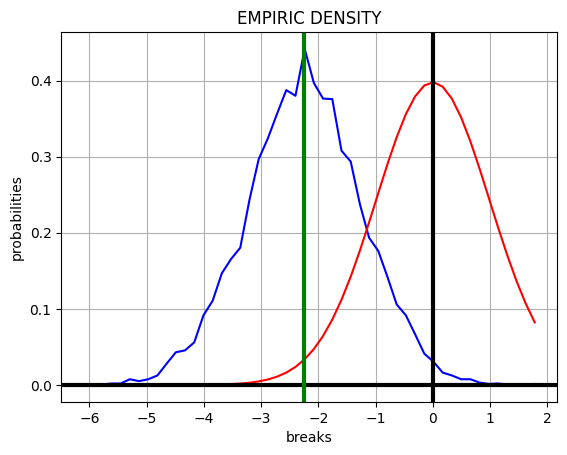

In [74]:
# ВИЗУАЛИЗАЦИЯ
def fStudent_gamma(x):
    return sps.t.pdf(x,df=DF_gamma_t,loc=0,scale=1)
Empiric_density(data=t_gamma, number_breaks=round(N_gamma_t/200), F=[fStudent_gamma],colors=['r'],mindata=min(t_gamma), maxdata=max(t_gamma),MEAN=True)

In [75]:
# ТЕСТ НА РАВЕНСТВО МАТЕМАТИЧЕСКИХ ОЖИДАНИЙ

alpha_t=0.1
STATISTIC_t=np.zeros(N_gamma_t)
PVALUE_t=np.zeros(N_gamma_t)
RESULT_t=np.zeros(N_gamma_t)
for i in range(N_gamma_t):
    STATISTIC_t[i]=sps.ttest_ind_from_stats(mean1=Means_gamma1_t[1], std1=Vars_gamma1_t[1], nobs1=T_gamma1_t, mean2=Means_gamma2_t[1], 
                                            std2=Vars_gamma2_t[1], nobs2=T_gamma2_t, equal_var=False, alternative='two-sided').statistic
    PVALUE_t[i]=sps.ttest_ind_from_stats(mean1=Means_gamma1_t[1], std1=Vars_gamma1_t[1], nobs1=T_gamma1_t, mean2=Means_gamma2_t[1], 
                                         std2=Vars_gamma2_t[1], nobs2=T_gamma2_t, equal_var=False, alternative='two-sided').pvalue
# Статистический анализ
t_gamma_stat=pval_stat1(PVALUE_t,alpha_t)
t_gamma_stat                    # частость принятия гипотезы в случае равных дисперсий


0.0

In [76]:
PVALUE_t

array([0.07184922, 0.07184922, 0.07184922, ..., 0.07184922, 0.07184922,
       0.07184922])

                                                  ЭКСПЕРИМЕНТЫ С РЕАЛЬНЫМИ ДАННЫМИ

In [ ]:
DJ=pyreadr.read_r("C:\\Users\\baputko\\Downloads\\DJ_COMPONENTS.RData")         #  словарь, полученный из данных R
CLOSE_DAILY_DJ=DJ['CLOSE_DAILY']                                        #  DataFrame цен, полученная по выбору ключа словаря
PRICES_DJ=CLOSE_DAILY_DJ.to_numpy()                                     #  np-array цен
RET_DJ=np.diff(np.log(PRICES_DJ),axis=0)                                #  Доходности
CLOSE_DAILY_DJ

                                                          Тест Колмогорова-Смирнова

In [ ]:
T_RET=100
RET_DJ_SUBS=subsamples_array(RET_DJ,T=T_RET,frombegin=True,axis=0)
RET_DJ_SUBS.shape

In [ ]:
RET_KS=np.zeros([RET_DJ_SUBS.shape[0],RET_DJ_SUBS.shape[2]])
for k in range(RET_DJ_SUBS.shape[0]):
    for j in range(RET_DJ_SUBS.shape[2]):
        RET_KS[k,j]=sps.ks_2samp(RET_DJ_SUBS[k,0:round(T_RET/2),j],RET_DJ_SUBS[k,round(T_RET/2):T_RET,j]).pvalue
pd_RET_KS=pd.DataFrame(RET_KS)
pd_RET_KS.columns=CLOSE_DAILY_DJ.columns
pd_RET_KS

In [ ]:
KS_ret_stat=pval_stat2(RET_KS,alpha_t,axis=0)
KS_ret_stat                    # частость принятия гипотезы 


In [ ]:
m=1
data=RET_DJ_SUBS[:,:,1]
 mean1[i]=np.mean(data[i,0:50])
    mean2[i]=np.mean(data[i,50:100])
    std1[i]=np.std(data[i,0:50])
    std2[i]=np.std(data[i,50:100])
data
for i in range(data.shape[0]):
    mean1[i]=np.mean(data[i,0:50])
    mean2[i]=np.mean(data[i,50:100])
    std1[i]=np.std(data[i,0:50])
    std2[i]=np.std(data[i,50:100])